<h1 align="center">ELECTRE METHOD - PHASE I SHOW</h1>

<h3>This notebook illustrates how the <b>ELECTRE-II</b> method is used to rank the best tenders for one Procurement Procedure Lot.</h3>

The algorithm followed for this goes as follows:

1. Extract data from an Excel file containing the comparative values assigned by 3 evaluators to a set of Quality AwardCriteria
2. Transform the extracted data into a Graph compliant with the CAV-Anticorrupzione-Application Profile TBox 
3. Load the data in a Graph Store
4. Query the Graph Store to retrieve the data
5. Rank the tender-lots
6. Visualise the results

In [1]:
import etl
import sparql as q
import store
import electre

<h2> Step #1: Extraction of the data from the excel file</h2>
<u><b>Note:</b></u>

If you want to change this file download it from <a href="./evaluation-tool.xlsm">here</a>, modify it and save it in the root directory of this notebook. 

In [2]:
EXCEL_FILE = 'evaluation-tool.xlsm'
DATA_TAB = 'REPORTS PER EVALUATOR'
CRITERIA_TAB = 'MAIN REPORT'
g = etl.graph()  # Creates the graph of the ABox
g, criteria = etl.instantiate_criteria(g, EXCEL_FILE, CRITERIA_TAB)
e = etl.extract(EXCEL_FILE, DATA_TAB)           # Creates a pandas data frame from the Excel dataset

<h4>Here you have an overview of the data in a pandas' data frame:</h4>

In [3]:
print(e)

                       C8 E1 E1.A E1.B E1.C E1.D E1.E E1.F E1.G E1.H  ...  \
4     1. Quality aspect 1  A  NaN   B2   A3   D2   A3   A2   A3   H2  ...   
5     1. Quality aspect 1  B  NaN  NaN   B2   D2   B2   B2   B3    1  ...   
6     1. Quality aspect 1  C  NaN  NaN  NaN   D4   E3   F3   G2   H4  ...   
7     1. Quality aspect 1  D  NaN  NaN  NaN  NaN   D2   D3   D4   D2  ...   
8     1. Quality aspect 1  E  NaN  NaN  NaN  NaN  NaN   E2   E3   H2  ...   
..                    ... ..  ...  ...  ...  ...  ...  ...  ...  ...  ...   
129  1. Quality aspect 11  F  NaN  NaN  NaN  NaN  NaN  NaN   F5   F3  ...   
130  1. Quality aspect 11  G  NaN  NaN  NaN  NaN  NaN  NaN  NaN   H3  ...   
131  1. Quality aspect 11  H  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
132  1. Quality aspect 11  I  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
133  1. Quality aspect 11  L  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   

    E3.A E3.B E3.C E3.D E3.E E3.F E3.G E3.H E3.I E3.L  
4    NaN   B3   A3 

<h2>Step #2: Creation of the CAV-AC-AP ABox</h2>

In [4]:
g, r = etl.build_roles(g)                       # Instantiates the role 'evaluator'
g, tl = etl.lots_tendered(g)                    # Instantiates TenderLots 'A' to 'L'
g = etl.transform(e, g, tl, r, criteria)        # Populates the graph

<h4>The results have been extracted into a file named 'a-box.ttl'. Here you have the contents (it's a long process, since it generates many triples, so you will have to wait a short while):</h4>

In [5]:
etl.show_save(g, True)

@prefix cap: <http://data.europa.eu/w21/2c930c7b-5e2f-4954-8522-bd3411339d6c/extension/cap#> .
@prefix cccev: <https://data.europe.eu/semanticassets/ns/cv/cccev_v2.0.0#> .
@prefix ct: <http://data.europa.eu/w21/2c930c7b-5e2f-4954-8522-bd3411339d6c/resource/criterion-type#> .
@prefix cv: <http://data.europa.eu/m8g#> .
@prefix epo: <http://data.europa.eu/a4g/ontology#> .
@prefix foaf: <http://xmlns.com/foaf/0.1/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix roles: <http://data.europa.eu/w21/2c930c7b-5e2f-4954-8522-bd3411339d6c/resource/role-type#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

cap:A-tender-lot-ccd760a9-dcdd-4c13-8508-3dada36ce383 a epo:TenderLot,
        owl:NamedIndividual ;
    epo:relatesTo epo:Lot1 .

cap:B-tender-lot-88cb4626-9140-416b-9392-55bb2348df8e a epo:TenderLot,
        owl:NamedIndividual ;
    epo:relatesTo epo:Lot1 .

cap:C-tender-lot-b53c0268-eaca-4f00-a520-6125a15c75cc a epo:Tend

<h2>Step #3: Store the graph into the Graph Store</h2>

<h4>We first connect to the Graph Store.</h4>
<p><b><u>Note</u></b>: This show uses a local GraphDB store and a repository named 'cav-pilot'. In your case you will have to have a Graph Store available, either locally or remotely, and re-configure the code (see the function 'connect()' inside the 
module 'store.py'.</p>

In [6]:
sparql = store.connect()

<h4>We then drop the current 'named graph', if any.</h4>

In [7]:
store.drop(sparql)

DROP done


<h4>Now we load the graph into the Graph Store (again, many triples are to be inserted, so wait a bit, please...)</h4>

In [8]:
store.insert(g, sparql)

INSERT done


<h2>Step #4: Query the Graph Store and retrieve the data per criterion, evaluator, etc.</h4>

<h4>4.1. Let us retrieve now the data from the Graph Store.</h4> 

4.1.1. The <b><u>User Story</u></b> for this operation goes as this:

<p><div align="center"><i>I, as the algorithm calculating and ranking which is the winner of Lot1 of the procurement procedure X, want to get all input values introduced by all evaluators for this procedure's lot and concerning exclusively 'Qualitative Subjective Criteria', so I can assess the deviations between the evaluators' decisions.</i></div></p>

4.1.2. The <b><u>Competency Question</u></b> goes like this:
<p><div align="center"><i>Retrieve all the input values assigned by all evaluators to 'Qualitative Subjective Criteria', as well as the information related to the input value.</i></div></p>

4.1.3. And the corresponding <b><u>SPARQL Query</u></b> like this:

    PREFIX cap: <http://data.europa.eu/w21/2c930c7b-5e2f-4954-8522-bd3411339d6c/extension/cap#>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX cccev: <https://data.europe.eu/semanticassets/ns/cv/cccev_v2.0.0#>
    PREFIX foaf: <http://xmlns.com/foaf/0.1/>
    PREFIX ct: <http://data.europa.eu/w21/2c930c7b-5e2f-4954-8522-bd3411339d6c/resource/criterion-type#>
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
    SELECT 	?input (concat(?givenName, " ", ?familyName) as ?agent) ?source ?target ?winner ?value (str(?crit) as ?criterion) (str(?cObj) as ?cid) 
            ?maxscore ?note
    FROM cap:
    WHERE {
        ?input rdf:type cap:InputValue ;
           cap:comparesSourceThing ?source ;
           cap:comparesWithTargetThing ?target ;
           cap:hasBetterCandidate ?winner ;
           cap:hasNumericValue ?value ;
           cap:isProvidedBy ?agentObj;
           cap:refersToCriterion ?cObj .
        ?cObj cccev:hasName ?crit ; 
                   cap:hasMaximumScore ?maxscore ;
                   skos:scopeNote ?note .
        ?agentObj foaf:givenName ?givenName ;
                  foaf:familyName ?familyName .

        FILTER EXISTS {?cObj cccev:hasType ct:qs}
        FILTER (?source != ?target && ?value != 0)

    } ORDER BY ?agent

<h4>4.2. So, let us execute this SPARQL query...</h4>

In [9]:
results = q._query(sparql)

4.2.1 The results are obtained as a ... <b>BIG</b> .. JSON object:

In [10]:
print(results)

{'head': {'vars': ['input', 'agent', 'source', 'target', 'winner', 'value', 'criterion', 'cid', 'maxscore', 'note']}, 'results': {'bindings': [{'input': {'type': 'uri', 'value': 'http://data.europa.eu/w21/2c930c7b-5e2f-4954-8522-bd3411339d6c/extension/cap#input-value-05a6e36a-8a17-417c-90f0-65cbe8d5ff42'}, 'note': {'xml:lang': 'en', 'type': 'literal', 'value': 'Qualitative Subjective Criterion'}, 'agent': {'type': 'literal', 'value': 'Alice Mauricius'}, 'winner': {'type': 'literal', 'value': 'even'}, 'criterion': {'type': 'literal', 'value': '1. Quality aspect 11'}, 'source': {'type': 'literal', 'value': 'D'}, 'maxscore': {'type': 'literal', 'value': '3'}, 'value': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '1'}, 'target': {'type': 'literal', 'value': 'L'}, 'cid': {'type': 'literal', 'value': 'http://data.europa.eu/w21/2c930c7b-5e2f-4954-8522-bd3411339d6c/extension/cap#criterion-131d62d76f82880345bfb89aa8d8473b'}}, {'input': {'type': 'uri', 'va

<h2>Step #5: Based on these results, we rank the tender-lots submitted by the tenderers</h2>

<h4>5.1. Let us get the J+ and P+, according to the ELECTRE-II, phase I algorithm:</h4>

In [11]:
j = electre.get_j(results)
print(j)

{'criterion-131d62d76f82880345bfb89aa8d8473b': {'max_score': 3, 'jw': [('D', 'L', 'even', '=', 'Alice Mauricius', 1, 0.33), ('A', 'H', 'A', '+', 'Alice Mauricius', 2, 0.67), ('G', 'B', 'L', '+', 'Alice Mauricius', 2, 0.67), ('A', 'B', 'even', '=', 'Alice Mauricius', 1, 0.33), ('D', 'H', 'D', '+', 'Alice Mauricius', 2, 0.67), ('B', 'L', 'even', '=', 'Alice Mauricius', 1, 0.33), ('A', 'G', 'A', '+', 'Alice Mauricius', 2, 0.67), ('C', 'L', 'I', '+', 'Alice Mauricius', 2, 0.67), ('G', 'L', 'I', '+', 'Alice Mauricius', 2, 0.67), ('E', 'B', 'E', '+', 'Alice Mauricius', 3, 1.0), ('I', 'B', 'I', '+', 'Alice Mauricius', 2, 0.67), ('E', 'G', 'even', '=', 'Alice Mauricius', 1, 0.33), ('A', 'L', 'even', '=', 'Alice Mauricius', 1, 0.33), ('C', 'B', 'C', '+', 'Alice Mauricius', 2, 0.67), ('A', 'B', 'A', '+', 'Alice Mauricius', 3, 1.0), ('H', 'B', 'H', '+', 'Alice Mauricius', 2, 0.67), ('D', 'B', 'D', '+', 'Alice Mauricius', 3, 1.0), ('A', 'D', 'A', '+', 'Alice Mauricius', 3, 1.0), ('B', 'H', 'B', '+

This function returns a collection of criteria and per each criterion, it's <u>maximum score</u>, the <u>source tender lot</u> and the <u>target tender-lot</u> represented both with one letter (A-L, without J nor K), the <u>best tender-lot</u> resulting from comparing source and target, it's <u>sign</u> (+, = or -), the name of the <u>evaluator</u>, the <u>value</u> assigned by the evaluator as a result of the tender-pair-evaluation, and its weight (resulting from dividing its value by the maximum score).

Next we show you an example for one positive criterion:

In [13]:
criterion = 'criterion-131d62d76f82880345bfb89aa8d8473b'
print('Criterion: {}'.format(criterion.split('-')[1]))
print('maximum score: {}'.format(j[criterion]['max_score']))
print('source tender-lot: {}'.format(j[criterion]['jw'][4][0]))
print('target tender-lot: {}'.format(j[criterion]['jw'][4][1]))
print('best tender-lot pair: {}'.format(j[criterion]['jw'][4][2]))
print('best tender-lot sign: {}'.format(j[criterion]['jw'][4][3]))
print('evaluator: {}'.format(j[criterion]['jw'][4][4]))
print('evaluator\'s assigned value : {}'.format(j[criterion]['jw'][4][5]))
print('relative weight (value / max_score) {}'.format(j[criterion]['jw'][4][6]))

Criterion: 131d62d76f82880345bfb89aa8d8473b
maximum score: 3
source tender-lot: D
target tender-lot: H
best tender-lot pair: D
best tender-lot sign: +
evaluator: Alice Mauricius
evaluator's assigned value : 2
relative weight (value / max_score) 0.67


<h4>5.2. With the individual J+ and P+ we can calculate the summation of each of the tender-lot weights per criteria.</h4>

<u><b>Note</b></u>: 
1. Remember that each tender-lot is represented by a letter from [A, L] without J nor K (do they not exist in Italian?).
2. The decimal number is the calculation of the P+ of all the criteria and all evaluators
3. Letters not printed out, except for J and K, are P= or P-, we are not interested in them, since P= is assigned a value '1', and P- a value of '0'.

In [14]:
p = electre.get_p(j)
print(p)

({'A': 0.3888888888888885, 'L': 0.3888888888888885, 'D': 0.6288888888888887, 'H': 0.6944444444444443, 'I': 0.19444444444444448, 'B': 0.41666666666666635, 'F': 0.3233333333333332, 'E': 0.24000000000000002, 'G': 0.05555555555555554}, {'even': 1.3611111111111147}, {})


<h4>5.3. Next we can check the <i>concordance</i> indices of each pair</h4>

<p>This calculation returns a JSON object with:</p>

1. the letter representing the best J+(a,a') tender-lot,
2. the decimal being the P+(a, a'), and 
3. the boolean telling us whether this tender-lot passes the threshold or not (True = pass, False= fails).


In [15]:
# collect the concordance indices c(a, a') = P+(a, a') / P=(a, a') >= c, where c = 3/4 ('natural threshold')
# or c = 2/3 ('strong threshold')
# The decision of choosing 3/4 or 2/3 is set in the call for tenders.
c = 2/3
k = electre.get_c(p[0], c)
print(k)

{'A': (0.3888888888888885, False), 'L': (0.3888888888888885, False), 'D': (0.6288888888888887, True), 'H': (0.6944444444444443, True), 'I': (0.19444444444444448, False), 'B': (0.41666666666666635, False), 'F': (0.3233333333333332, False), 'E': (0.24000000000000002, False), 'G': (0.05555555555555554, False)}


<h4>5.4 Finally we rank the winners, sorted by score</h4>

In [17]:
r = electre.rank(k)
for key in r:
    print('tender-lot: {0} -> score: {1} -> concordance threshold: {2}'.format(
        key[0], 
        round(key[1][0], 2), 
        'ABOVE (PASSES)' if key[1][1] else 'BELOW'))


tender-lot: H -> score: 0.69 -> concordance threshold: ABOVE (PASSES)
tender-lot: D -> score: 0.63 -> concordance threshold: ABOVE (PASSES)
tender-lot: B -> score: 0.42 -> concordance threshold: BELOW
tender-lot: A -> score: 0.39 -> concordance threshold: BELOW
tender-lot: L -> score: 0.39 -> concordance threshold: BELOW
tender-lot: F -> score: 0.32 -> concordance threshold: BELOW
tender-lot: E -> score: 0.24 -> concordance threshold: BELOW
tender-lot: I -> score: 0.19 -> concordance threshold: BELOW
tender-lot: G -> score: 0.06 -> concordance threshold: BELOW


<h2>6. Visualise the results</h2>

<h4>6.1. With these data one can start thinking about how to visualise the data...</h4>

e.g. a simple bar chart used to glimpse the differences between the tender-lots:

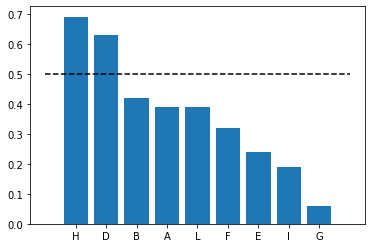

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
x = []
y = []
threshold = 0.5
for key in r:
    x.append(key[0])
    y.append(round(key[1][0], 2))
    
plt.bar(x, y)
plt.xticks(x)
plt.plot([-1, len(x)], [0.5, .5], "k--")
plt.show()
             

<h4>6.2. Similar to the above, but as an area chart:</h4>

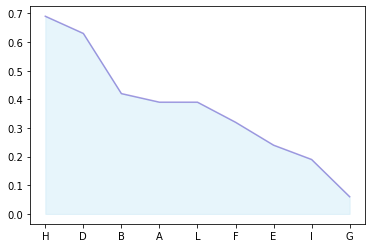

In [19]:
plt.fill_between( x, y, color="skyblue", alpha=0.2)
p = plt.plot(x, y, color="Slateblue", alpha=0.6)

<h4>6.3. Other nice-to-have and TODO visualisations...for example:</h4>

* Spider chart per Quality Criterion and per tender-lot
* Standard deviation chart for all criteria, evaluators and tender-lots
* Other ...